# Task 2 Skeleton Code

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 10,10

import sklearn.datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Original Data

In [52]:
my_iris_data = sklearn.datasets.load_iris()
print ("my_iris_data.data.shape:",my_iris_data.data.shape)
print ("labels:",my_iris_data.target)

my_iris_data.data.shape: (150, 4)
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [53]:
X_train = np.concatenate((my_iris_data.data[10:50,:],my_iris_data.data[60:100,:], my_iris_data.data[110:150,:]))
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1) # Append bias term 1
y_train = np.concatenate((my_iris_data.target[10:50],my_iris_data.target[60:100], my_iris_data.target[110:150]))
print ("X_train.shape:", X_train.shape)
print ("y_train.shape:", y_train.shape)

X_test = np.concatenate((my_iris_data.data[40:50,:],my_iris_data.data[90:100,:], my_iris_data.data[140:150,:]))
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1) # Append bias term 1
y_test = np.concatenate((my_iris_data.target[40:50],my_iris_data.target[90:100], my_iris_data.target[140:150]))
print ("X_test.shape:", X_test.shape)
print ("y_test.shape:", y_test.shape)

X_train.shape: (120, 5)
y_train.shape: (120,)
X_test.shape: (30, 5)
y_test.shape: (30,)


## Preprocess the labels to get 3 datasets

In [54]:
y_train1 = np.copy(y_train); y_test1 = np.copy(y_test)
y_train2 = np.copy(y_train); y_test2 = np.copy(y_test)
y_train3 = np.copy(y_train); y_test3 = np.copy(y_test)

y_train1[y_train == 1] = -1
y_train1[y_train == 2] = -1
y_train1[y_train == 0] = 1
y_test1[y_test == 1] = -1
y_test1[y_test == 2] = -1
y_test1[y_test == 0] = 1

y_train2[y_train == 1] = 1
y_train2[y_train == 2] = -1
y_train2[y_train == 0] = -1
y_test2[y_test == 1] = 1
y_test2[y_test == 2] = -1
y_test2[y_test == 0] = -1

y_train3[y_train == 1] = -1
y_train3[y_train == 2] = 1
y_train3[y_train == 0] = -1
y_test3[y_test == 1] = -1
y_test3[y_test == 2] = 1
y_test3[y_test == 0] = -1

## Task 2: OvA SVM on iris
We use gradient descent to train 3 SVMs

Original target function: 

$ L(\textbf{w}) = \frac{1}{2} \left \| \textbf{w} \right \|^2 + C \sum_i max(0, 1- y_i \times <\textbf{x}_i, \textbf{w}>) $

The gradient w.r.t $\textbf{w}$ of the target function:

$ L'(\textbf{w})=\frac{d L(\textbf{w})}{d \textbf{w}} = \textbf{w} +C \sum_i \left\{\begin{matrix} -y_i  \textbf{x}_i & \text{, if }  y_i \times < \textbf{x}_i, \textbf{w}> \le 1\\ 
0 & \texttt{, otherwise} 
\end{matrix}\right. $

In [55]:
C=10 # the lambda
learning_rate = 0.0001 # the alpha
n_iter = 20000
iterations = []

In [56]:
# gradient of loss function L(w)
def L_prime_w(X, Y, w):
    ########### YOUR CODE HERE ###########
    grad = w.copy()

    for i in range(X.shape[0]):
        if (Y[i] * np.dot(X[i], w) <= 1):
            X_i_col = X[i].reshape(-1, 1)
            grad += C * (-Y[i] * X_i_col)
    return grad

In [57]:
def L_w(X, Y, w):
    ########### YOUR CODE HERE ###########
    ret = 0.5 * np.dot(w,w)

    for i in range(X.shape[0]):
        margin = 1 - Y[i] * np.dot(X[i], w)
        ret += C * max(0, margin)
    return ret

In [58]:
#w = np.random.randn(X_train.shape[1], 1)
def train_svm(X_train, Y_train):
    w = np.zeros((X_train.shape[1],1))
    
    for i in range(n_iter):
        gradient = L_prime_w(X_train, Y_train, w)
        w_new = w - learning_rate * gradient
        iterations.append(i+1)

        if np.linalg.norm(w_new - w, ord = 1) < 0.001:
            print("gradient descent has converged after " + str(i) + " iterations")
            break
        if i % 1000 == 0:
            print(i, np.linalg.norm(w_new - w, ord = 1))
        w = w_new
    return w

### (Warning! The next cell takes time to finish the descending)

In [59]:
w1 = np.copy(train_svm(X_train, y_train1))
print ("w1 vector:",  w1.tolist())
w2 = np.copy(train_svm(X_train, y_train2))
print ("w2 vector:",  w2.tolist())
w3 = np.copy(train_svm(X_train, y_train3))
print ("w3 vector:",  w3.tolist())

0 0.8825
gradient descent has converged after 165 iterations
w1 vector: [[0.13706870445168148], [0.22387327285027697], [0.6217347797476848], [-1.0914360336784863], [-0.5115724852430602]]
0 0.5650999999999999
1000 0.46095536243565094
2000 0.36728835264384024
3000 0.4197501456319785
4000 0.43329862753334714
5000 0.43223791544773627
6000 0.4322682446468791
7000 0.35929031569045944
8000 0.4026155586485771
9000 0.4217401032093835
10000 0.4026564584524035
11000 0.42177458618252395
12000 0.4026896359188892
13000 0.40270111318761326
14000 0.4330117270694182
15000 0.3594137779450923
16000 0.37031714837672014
17000 0.37031698615511516
18000 0.37031689739481044
19000 0.3703172698110826
w2 vector: [[6.391768255010401], [-0.31933682516823203], [-2.250233767106934], [1.6890043991911392], [-3.3047100220482406]]
0 0.3689
1000 0.01895838433401842
2000 0.0031263054072552254
3000 0.053403942484862243
4000 0.027836688344175187
5000 0.027744036668115424
6000 0.027878118095105764
7000 0.009915442457714363
8

In [60]:
w= np.concatenate((w1,w2,w3),axis=1)
print ("w.shape:", w.shape)

w.shape: (5, 3)


In [61]:
def eva_accuracy(X_train, y_train, w):
    prediction = 2 * (np.dot(X_train, w) >= 0) - 1
    accuracy = np.sum(prediction == y_train.reshape(-1, 1))*1.0/X_train.shape[0]
    return accuracy
#print(prediction.shape, Y_test.shape)
accuracy1 = eva_accuracy(X_train, y_train1, w1)
print ("training accuracy1: " + str(accuracy1))
accuracy2 = eva_accuracy(X_train, y_train2, w2)
print ("training accuracy2: " + str(accuracy2))
accuracy3 = eva_accuracy(X_train, y_train3, w3)
print ("training accuracy3: " + str(accuracy3))

training accuracy1: 1.0
training accuracy2: 0.775
training accuracy3: 0.9583333333333334


### Results on training set

In [62]:
prediction1 = np.dot(X_train, w1)
prediction2 = np.dot(X_train, w2)
prediction3 = np.dot(X_train, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]
print ("Total training accuracy:", total_accuracy*100, "%.")

Total training accuracy: 95.83333333333334 %.


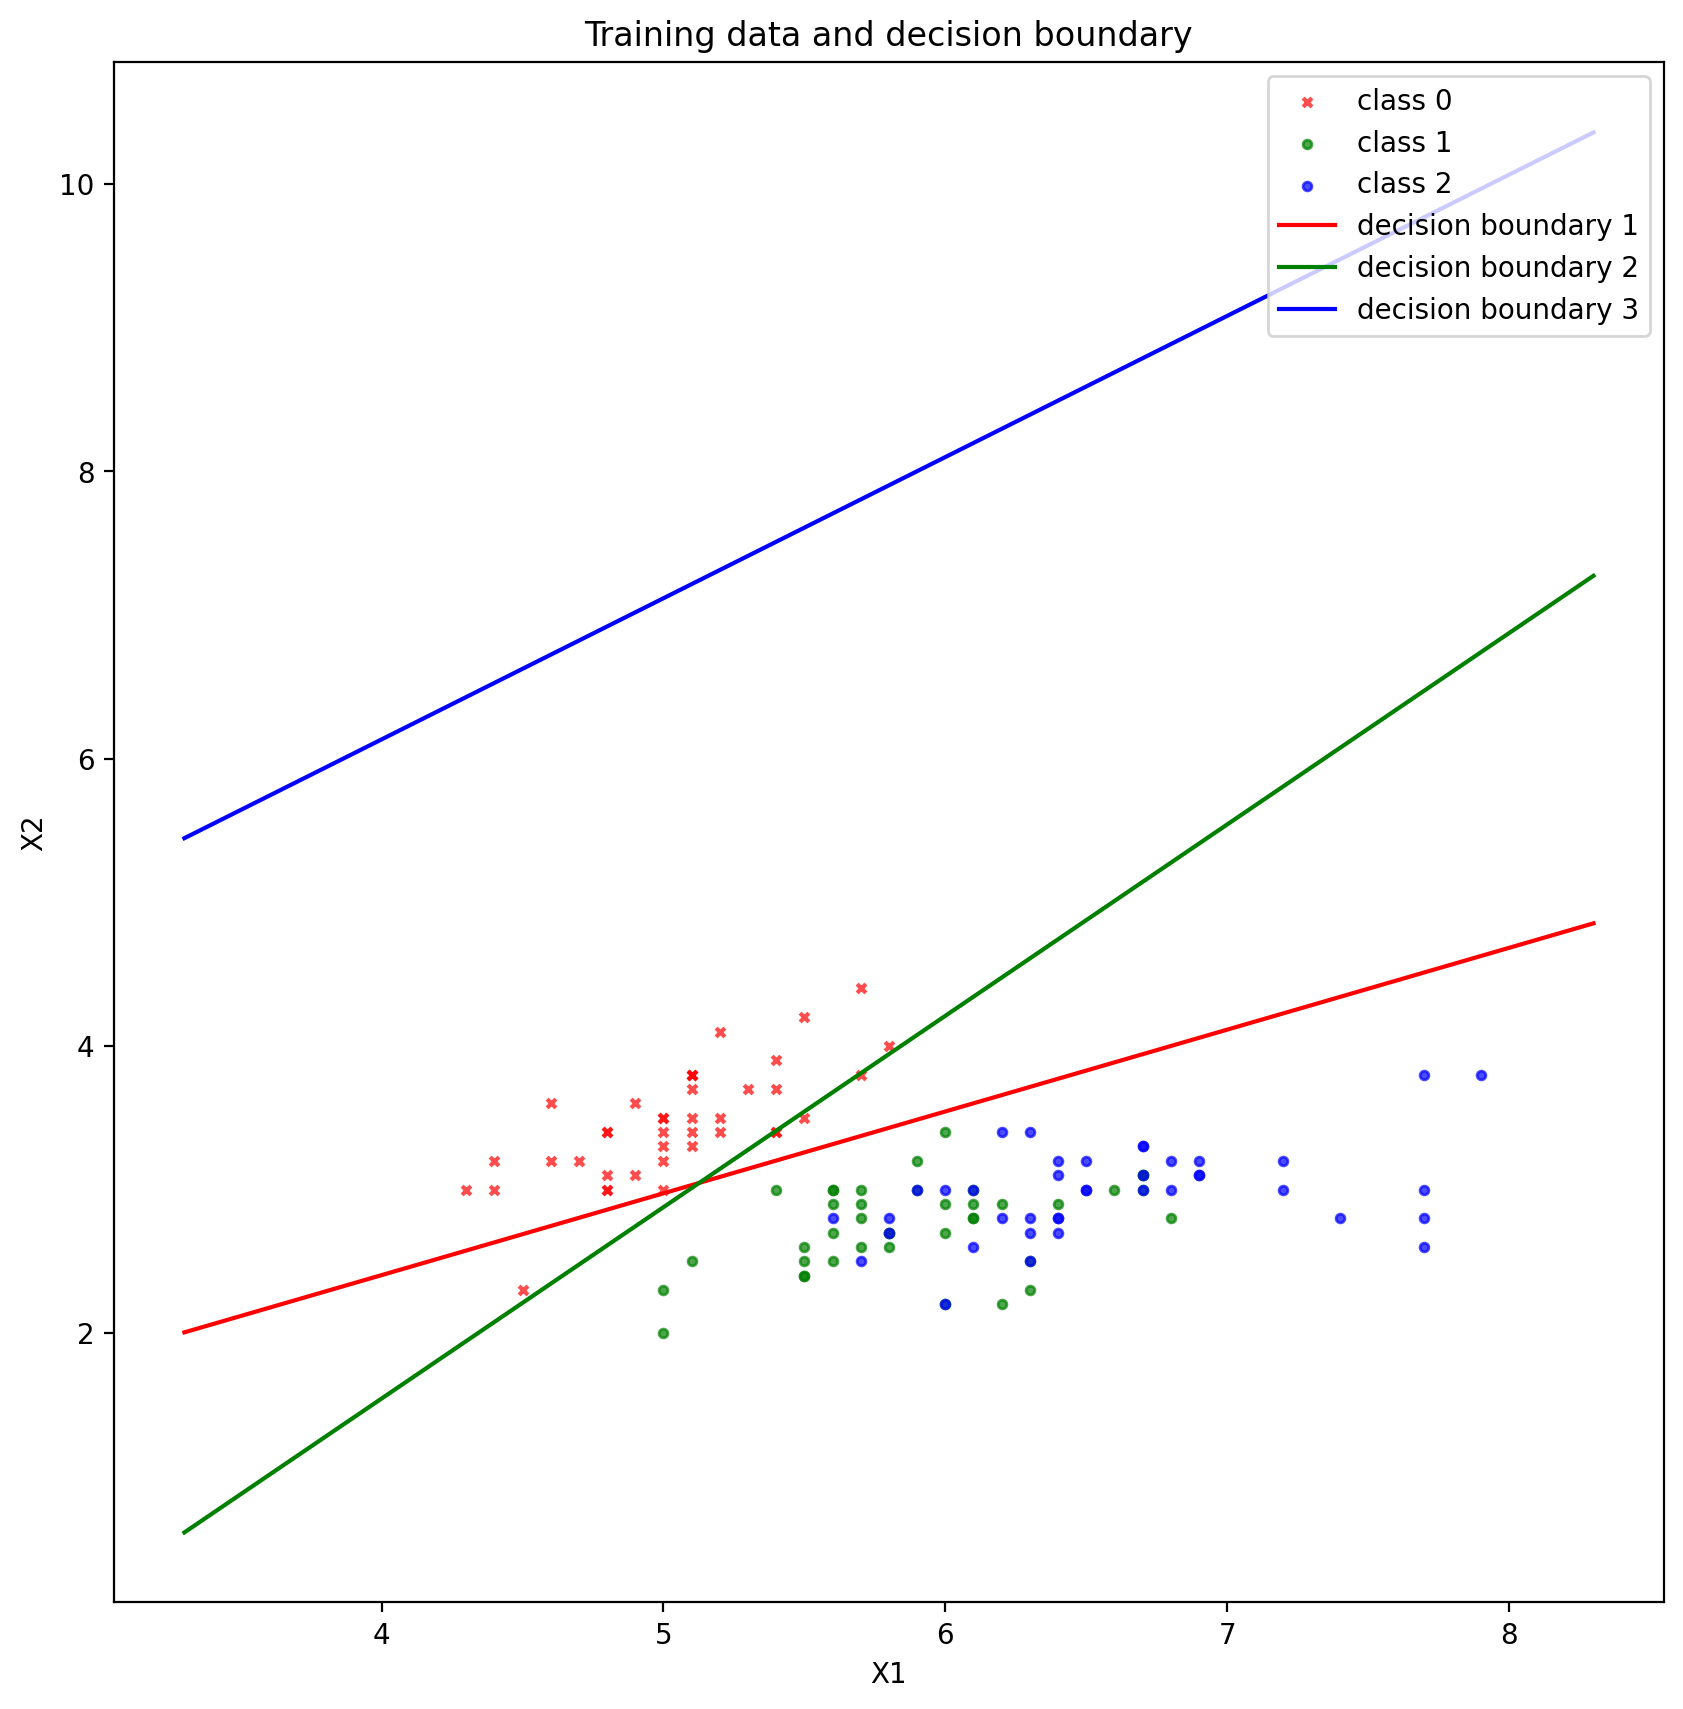

In [63]:
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)

### Results on test set

In [64]:
prediction1 = np.dot(X_test, w1)
prediction2 = np.dot(X_test, w2)
prediction3 = np.dot(X_test, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
print ("Total test accuracy:", total_accuracy*100, "%.")

Total test accuracy: 100.0 %.


## Report

0 0.044125
gradient descent has converged after 285 iterations
0 0.028255
gradient descent has converged after 84 iterations
0 0.01844500000000001
1000 0.0020738739393328376
gradient descent has converged after 1829 iterations
C=0.5: Training accuracy: 77.50%, Test accuracy: 76.67%
Optimal w for C=0.5:
w1: [ 0.07310838  0.12437978  0.44994829 -0.67927647 -0.28988865]
w2: [-0.02974211 -0.11417505 -0.14770432  0.04619345  0.00354034]
w3: [-0.46651108 -0.86073768 -0.6822599   1.22870435  1.15028344]
0 0.1765
gradient descent has converged after 301 iterations
0 0.11302
1000 0.004700867331532771
2000 0.005761956839541615
3000 0.00124683500794448
4000 0.004399318290203791
5000 0.002001649048812282
gradient descent has converged after 5901 iterations
0 0.07378000000000004
1000 0.0015417187596727944
2000 0.0024911105390710286
3000 0.0017302904004055097
gradient descent has converged after 3743 iterations
C=2.0: Training accuracy: 93.33%, Test accuracy: 100.00%
Optimal w for C=2.0:
w1: [ 0.094

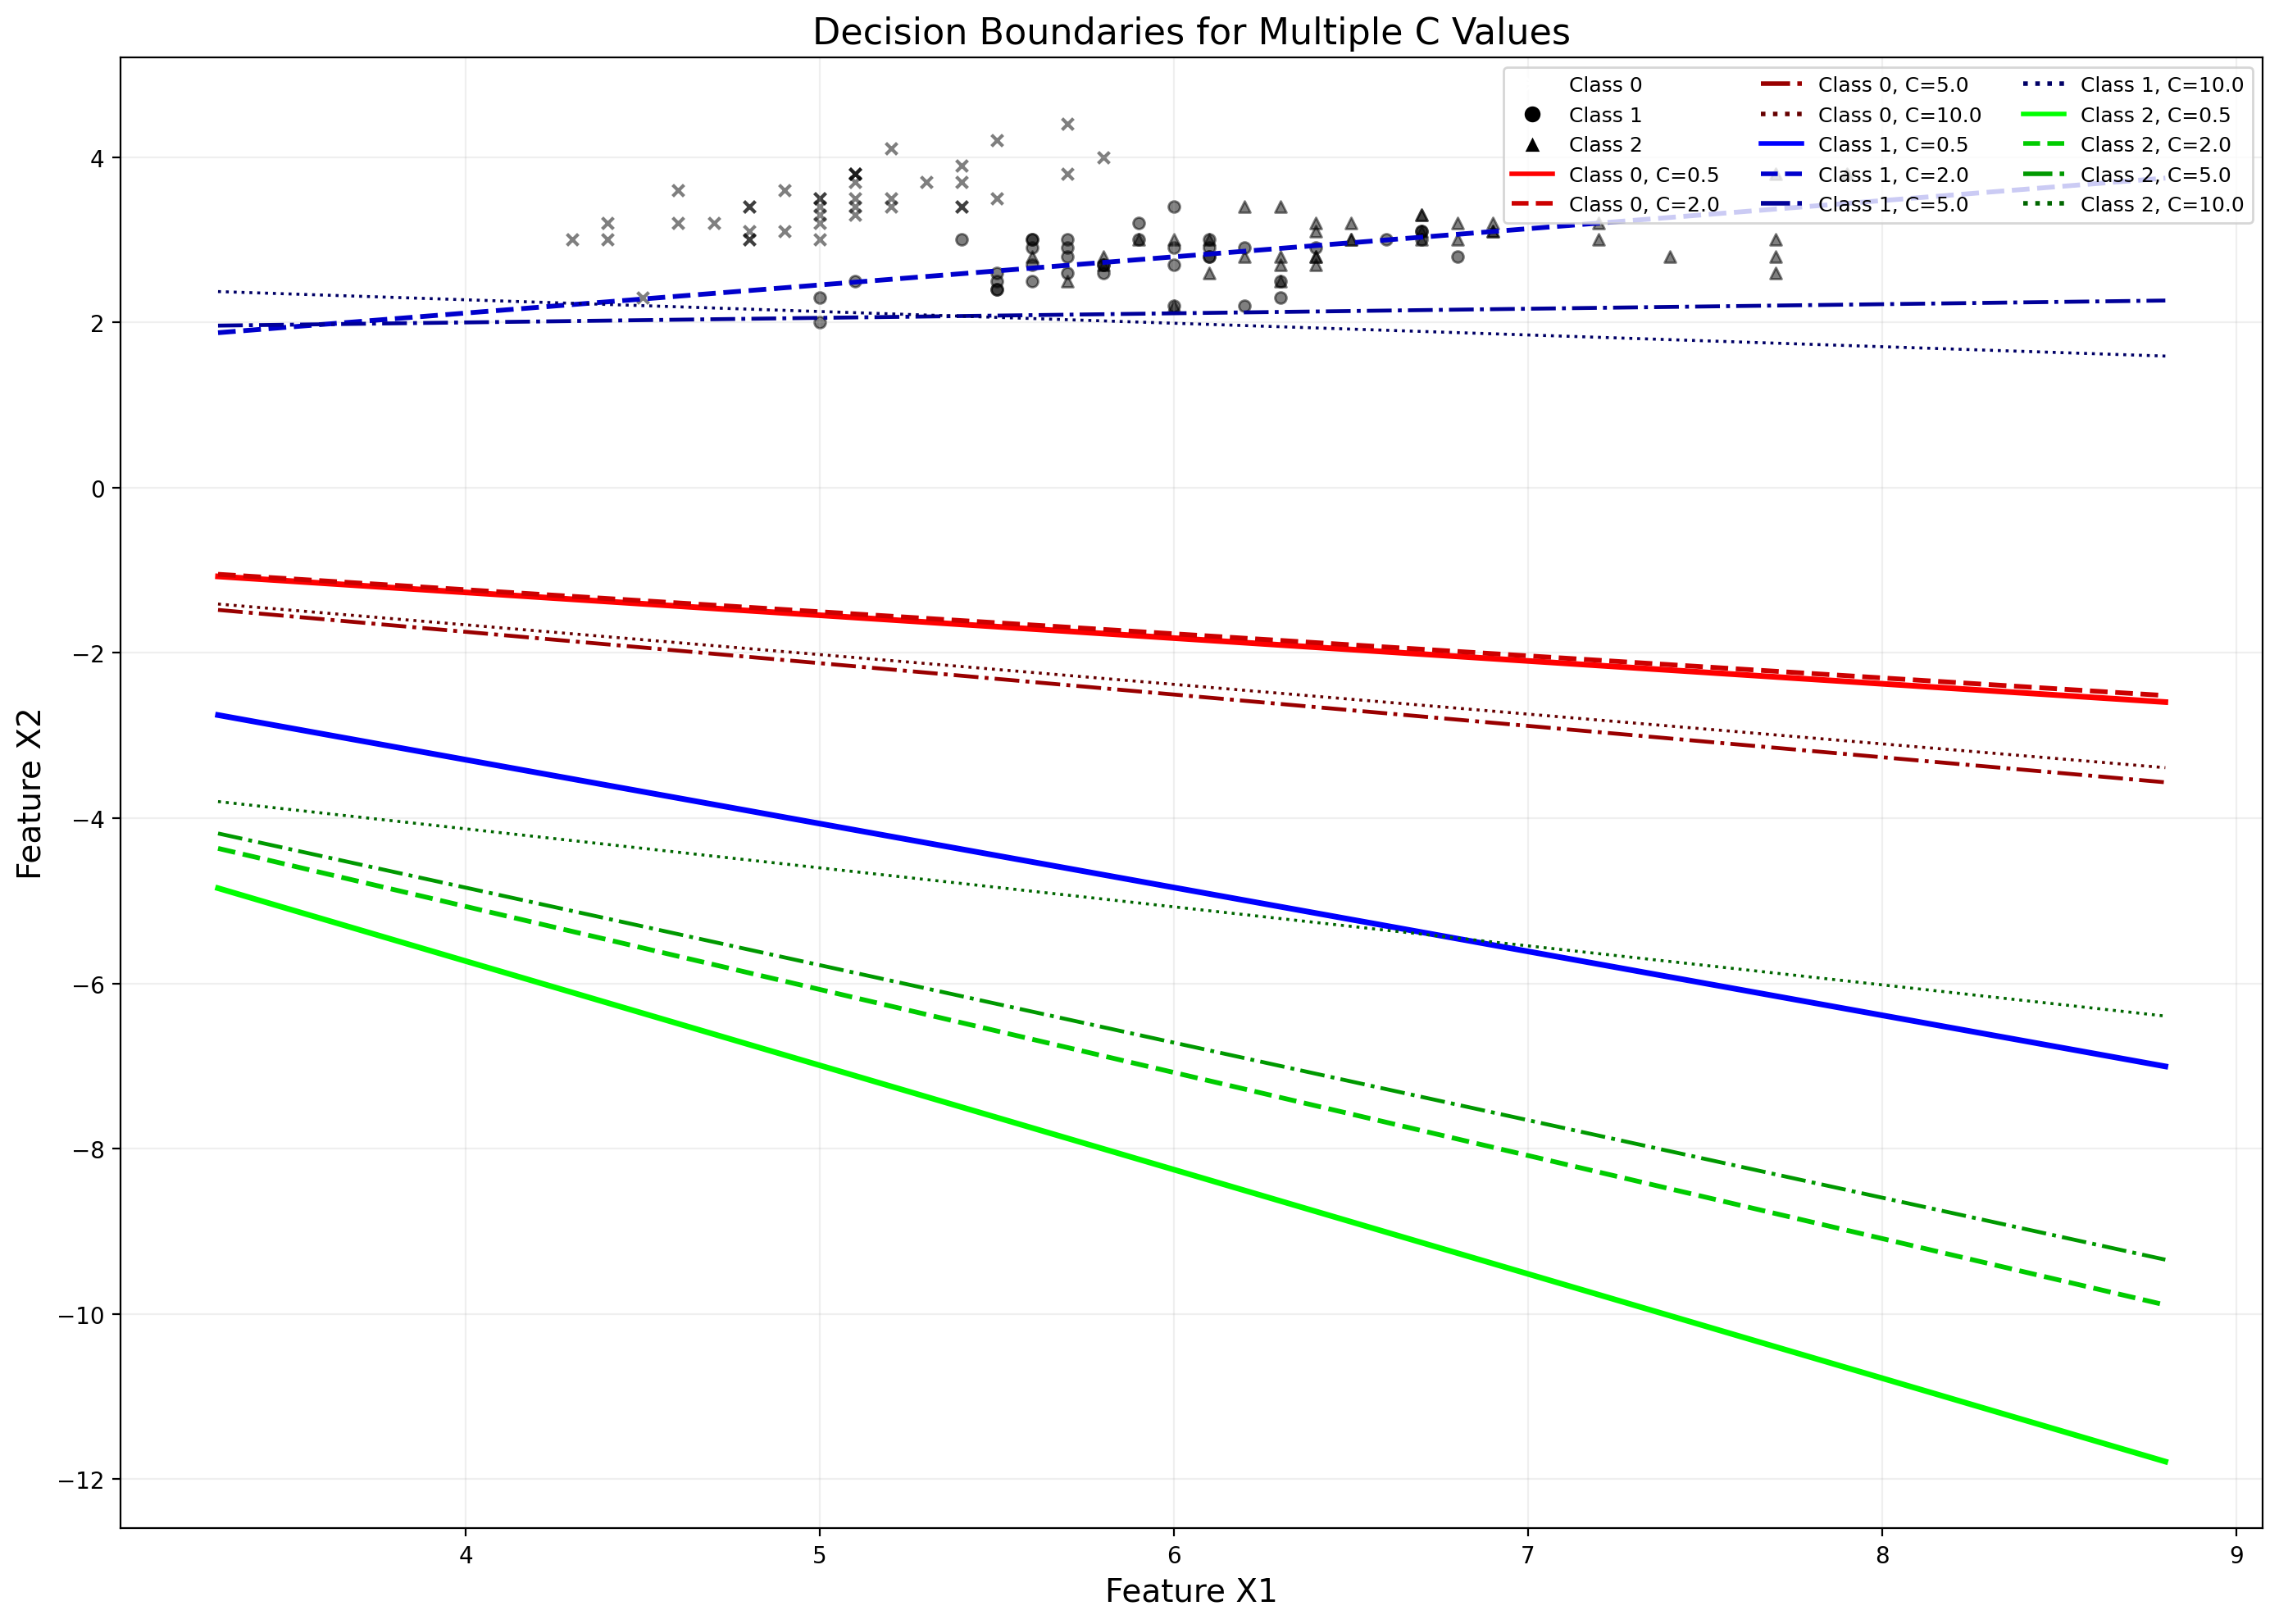

      C Training Accuracy Test Accuracy  \
0   0.5            0.7750        0.7667   
1   2.0            0.9333        1.0000   
2   5.0            0.9250        1.0000   
3  10.0            0.9583        1.0000   

                                          w1  \
0  [ 0.0731  0.1244  0.4499 -0.6793 -0.2899]   
1  [ 0.0945  0.1494  0.5599 -0.861  -0.389 ]   
2  [ 0.1384  0.23    0.6064 -1.0855 -0.5228]   
3  [ 0.1371  0.2239  0.6217 -1.0914 -0.5116]   

                                          w2  \
0  [-0.0297 -0.1142 -0.1477  0.0462  0.0035]   
1  [ 1.3604  0.6156 -1.8098  0.6244 -2.0043]   
2  [ 3.4368  0.1067 -1.9329  1.2536 -2.8824]   
3  [ 6.3918 -0.3193 -2.2502  1.689  -3.3047]   

                                          w3  
0  [-0.4665 -0.8607 -0.6823  1.2287  1.1503]  
1  [-1.3319 -1.2737 -1.2679  1.8314  2.4579]  
2  [-1.6187 -1.3928 -1.4851  2.0818  2.7075]  
3  [-4.4073 -0.928  -1.9662  2.0005  3.7037]  


In [66]:
import pandas as pd

results = []
C_values = [0.5, 2.0, 5.0, 10.0]
boundaries = []

plt.figure(figsize=(14, 10))

# Plot training data points
x1 = 1; x2 = 2
plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='k', alpha=0.5, s=25, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='k', alpha=0.5, s=25, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='^', color='k', alpha=0.5, s=25, label='class 2')

# Colors for each class and C value
class0_colors = ['#FF0000', '#CC0000', '#990000', '#660000']  # Reds
class1_colors = ['#0000FF', '#0000CC', '#000099', '#000066']  # Blues
class2_colors = ['#00FF00', '#00CC00', '#009900', '#006600']  # Greens

# Line styles
line_styles = ['-', '--', '-.', ':']

for i, C_val in enumerate(C_values):
    global C
    C = C_val

    # Train SVM for each class
    w1 = np.copy(train_svm(X_train, y_train1))
    w2 = np.copy(train_svm(X_train, y_train2))
    w3 = np.copy(train_svm(X_train, y_train3))
    
    w = np.concatenate((w1, w2, w3), axis=1)
    
    # Calculate accuracies
    prediction1 = np.dot(X_train, w1)
    prediction2 = np.dot(X_train, w2)
    prediction3 = np.dot(X_train, w3)
    preds = np.concatenate((prediction1, prediction2, prediction3), axis=1)
    pred = np.argmax(preds, axis=1)
    train_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]

    prediction1 = np.dot(X_test, w1)
    prediction2 = np.dot(X_test, w2)
    prediction3 = np.dot(X_test, w3)
    preds = np.concatenate((prediction1, prediction2, prediction3), axis=1)
    pred = np.argmax(preds, axis=1)
    test_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
    
    print(f"C={C_val}: Training accuracy: {train_accuracy*100:.2f}%, Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Optimal w for C={C_val}:")
    print(f"w1: {w1.flatten()}")
    print(f"w2: {w2.flatten()}")
    print(f"w3: {w3.flatten()}")
    
    # Store results
    results.append({
        'C': C_val,
        'Training Accuracy': f"{train_accuracy:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}",
        'w1': str(np.round(w1.flatten(), 4)),
        'w2': str(np.round(w2.flatten(), 4)),
        'w3': str(np.round(w3.flatten(), 4))
    })

    # Calculate decision boundaries
    x = np.arange(np.min(X_train[:,x1])-1, np.max(X_train[:,x1])+1, 0.1)  # Smaller step for smoother lines
    y1 = (-w[0][0]-w[x1][0]*x)/w[x2][0]
    y2 = (-w[0][1]-w[x1][1]*x)/w[x2][1]
    y3 = (-w[0][2]-w[x1][2]*x)/w[x2][2]
    
    # Plot decision boundaries for each class with its own color family
    plt.plot(x, y1, linestyle=line_styles[i], color=class0_colors[i], 
             linewidth=2.5-i*0.4, label=f'Class 0, C={C_val}')
    plt.plot(x, y2, linestyle=line_styles[i], color=class1_colors[i], 
             linewidth=2.5-i*0.4, label=f'Class 1, C={C_val}')
    plt.plot(x, y3, linestyle=line_styles[i], color=class2_colors[i], 
             linewidth=2.5-i*0.4, label=f'Class 2, C={C_val}')

plt.xlabel('Feature X1', fontsize=14)
plt.ylabel('Feature X2', fontsize=14)
plt.title('Decision Boundaries for Multiple C Values', fontsize=16)
plt.grid(alpha=0.2)

# Create a custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='x', color='w', markerfacecolor='k', markersize=8, label='Class 0'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='Class 1'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=8, label='Class 2'),
]

for i, C_val in enumerate(C_values):
    legend_elements.append(Line2D([0], [0], color=class0_colors[i], 
                                 linestyle=line_styles[i], lw=2, 
                                 label=f'Class 0, C={C_val}'))

for i, C_val in enumerate(C_values):
    legend_elements.append(Line2D([0], [0], color=class1_colors[i], 
                                 linestyle=line_styles[i], lw=2, 
                                 label=f'Class 1, C={C_val}'))

for i, C_val in enumerate(C_values):
    legend_elements.append(Line2D([0], [0], color=class2_colors[i], 
                                 linestyle=line_styles[i], lw=2, 
                                 label=f'Class 2, C={C_val}'))

plt.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=3)
plt.tight_layout()
plt.savefig('svm_all_boundaries.png', dpi=300)
plt.show()

# Display results table
results_df = pd.DataFrame(results)
print(results_df[['C', 'Training Accuracy', 'Test Accuracy']])